In [2]:
!pip install augly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.3/24.3 MB 21.7 MB/s eta 0:00:00
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31528 sha256=fb198c6e905dd549cd8ea78eb9a14daac58acc795a2e3b489231a0d3ea164f40
  Stored in directory: /root/.cache/pip/wheels/ba/5e/16/6117f8fe7e9c0c161a795e10d94645ebcf301ccbd01f66d8ec
Successfully built iopath


In [17]:
import os
from sklearn.model_selection import train_test_split
import augly.image as imaugs
import random
import PIL.Image
import matplotlib.pyplot as plt
import os
import random
from glob import glob
from tqdm import tqdm
import PIL.Image
import augly.image.functional as imaugs
import torch
import torchvision.transforms as transforms
from torchvision import models
from transformers import AutoModel
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import os
from torchvision import datasets
from torch.utils.data import DataLoader
from transformers import AutoModelForImageClassification, AutoFeatureExtractor
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
dataset_path = "/content/drive/MyDrive/test"  # Change if needed
train_path = "/content/drive/MyDrive/test/train"
test_path = "/content/drive/MyDrive/test/test_split"

# Create train and test directories
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Get all image file paths
cat_images = [os.path.join(dataset_path, "cats", img) for img in os.listdir(os.path.join(dataset_path, "cats"))]
dog_images = [os.path.join(dataset_path, "dogs", img) for img in os.listdir(os.path.join(dataset_path, "dogs"))]

# Split into train (80%) and test (20%)
cat_train, cat_test = train_test_split(cat_images, test_size=0.2, random_state=42)
dog_train, dog_test = train_test_split(dog_images, test_size=0.2, random_state=42)

# Create category-specific folders in train and test sets
for folder in ["cats", "dogs"]:
    os.makedirs(os.path.join(train_path, folder), exist_ok=True)
    os.makedirs(os.path.join(test_path, folder), exist_ok=True)

# Function to copy images instead of moving them
def copy_images(file_list, dest_folder):
    for file in file_list:
        shutil.copy(file, os.path.join(dest_folder, os.path.basename(file)))

# Copy images to train and test directories
copy_images(cat_train, os.path.join(train_path, "cats"))
copy_images(dog_train, os.path.join(train_path, "dogs"))
copy_images(cat_test, os.path.join(test_path, "cats"))
copy_images(dog_test, os.path.join(test_path, "dogs"))

print("Dataset successfully split into train and test sets without modifying the original images.")


Dataset successfully split into train and test sets without modifying the original images.


In [7]:


def apply_random_augmentations(image_path, num_augmentations=3):
    """
    Apply multiple random augmentations from AugLy to an image.
    Parameters:
    - image_path: Path to the input image
    - num_augmentations: Number of random augmentations to apply (default = 3)
    Returns:
    - Augmented image (PIL.Image object)
    """
    # Load the image
    img = PIL.Image.open(image_path).convert("RGB")

    # Define a list of available functional augmentations
    augmentations = [
        lambda x: imaugs.rotate(x, degrees=random.uniform(-30, 30)),  # Rotation
        lambda x: imaugs.crop(x, x1=0.15, y1=0.15, x2=0.85, y2=0.85),  # Cropping
        lambda x: imaugs.blur(x, radius=random.uniform(1, 3)),  # Blur
        lambda x: imaugs.color_jitter(x, brightness_factor=1.2, contrast_factor=1.2, saturation_factor=1.2),  # Color Jitter
        lambda x: imaugs.grayscale(x, mode="luminosity"),  # Convert to Grayscale
        lambda x: imaugs.brightness(x, factor=random.uniform(0.7, 1.3)),  # Brightness
        lambda x: imaugs.shuffle_pixels(x, factor=random.uniform(0.1, 0.5)),  # Pixel Shuffle (New)
        lambda x: imaugs.hflip(x),  # Horizontal Flip
        lambda x: imaugs.contrast(x, factor=random.uniform(0.5, 1.5)),  # Contrast Adjustment
        lambda x: imaugs.change_aspect_ratio(x, ratio=random.uniform(0.8, 1.2)),  # Aspect Ratio Change
    ]

    # Randomly choose augmentations to apply
    chosen_augmentations = random.sample(augmentations, num_augmentations)

    # Apply augmentations sequentially
    for aug in chosen_augmentations:
        img = aug(img)

    return img


In [8]:


# Define original paths
train_dir = "/content/drive/MyDrive/test/train"  # Original train folder
test_dir = "/content/drive/MyDrive/test/test_split"  # Test folder
aug_train_dir = "/content/drive/MyDrive/test/train_augmented"  # Augmented train folder

categories = ["cats", "dogs"]

# Function to copy the train folder
def copy_train_folder(src, dest):
    if os.path.exists(dest):
        shutil.rmtree(dest)  # Remove existing copy if any
    shutil.copytree(src, dest)
    print(f"Copied train dataset to {dest}")

# Function to save augmented images
def save_augmented_image(image, save_path, filename, count):
    new_filename = f"{os.path.splitext(filename)[0]}_aug{count}.jpg"
    image.save(os.path.join(save_path, new_filename))

# Copy the train dataset before augmentation
copy_train_folder(train_dir, aug_train_dir)

# Get dataset statistics before augmentation
original_train_counts = {cat: len(os.listdir(os.path.join(aug_train_dir, cat))) for cat in categories}
original_test_counts = {cat: len(os.listdir(os.path.join(test_dir, cat))) for cat in categories}

print(f"Original Train Set Count (Copied): {original_train_counts}")
print(f"Original Test Set Count: {original_test_counts}")


# Augment images in the copied train folder
for category in categories:
    cat_path = os.path.join(aug_train_dir, category)
    images = [img for img in os.listdir(cat_path) if img.lower().endswith(('png', 'jpg', 'jpeg'))]

    for image_name in images:
        image_path = os.path.join(cat_path, image_name)

        # Apply augmentation twice with different transformations
        aug_img1 = apply_random_augmentations(image_path, num_augmentations=3)
        aug_img2 = apply_random_augmentations(image_path, num_augmentations=3)

        # Save the augmented images
        save_augmented_image(aug_img1, cat_path, image_name, 1)
        save_augmented_image(aug_img2, cat_path, image_name, 2)

print("Augmentation completed on copied dataset.")


Copied train dataset to /content/drive/MyDrive/test/train_augmented
Original Train Set Count (Copied): {'cats': 56, 'dogs': 56}
Original Test Set Count: {'cats': 14, 'dogs': 14}
Augmentation completed on copied dataset.


In [13]:
print(new_train_counts)

{'cats': 168, 'dogs': 168}


New Train Set Count After Augmentation: {'cats': 168, 'dogs': 168}


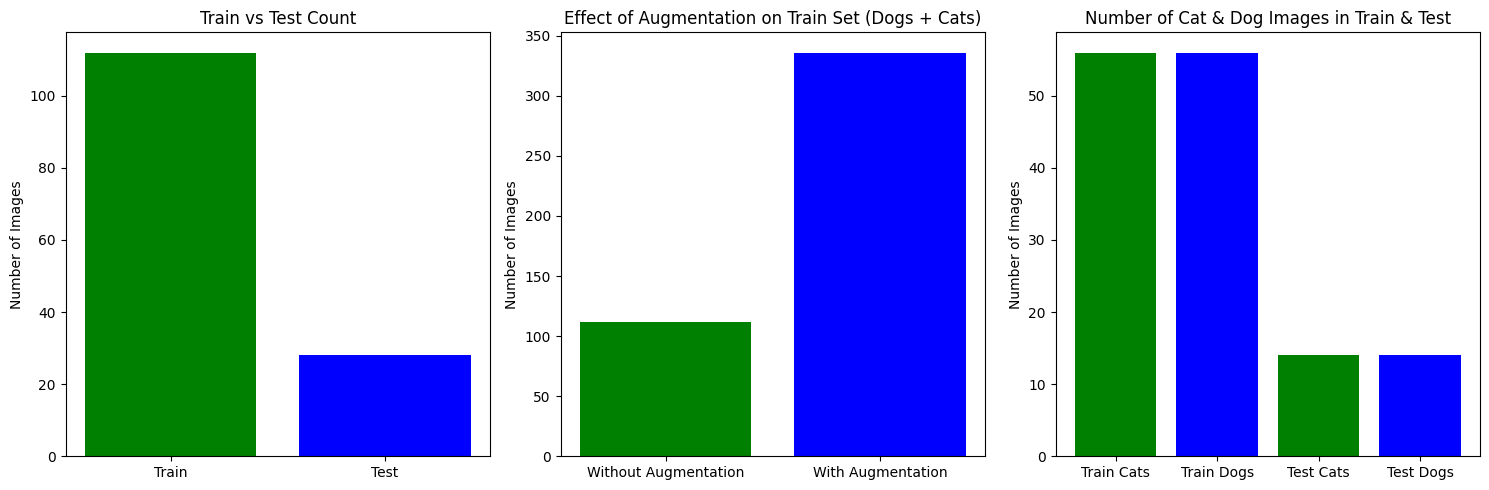

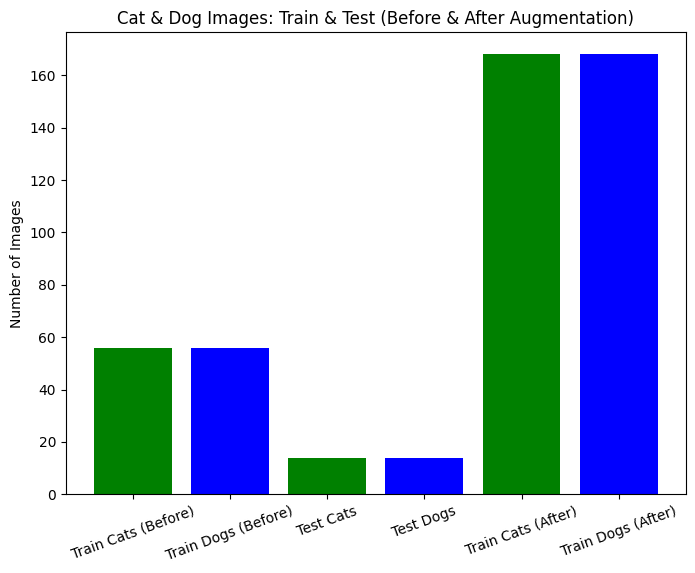

In [14]:
original_train_counts = {cat: len(os.listdir(os.path.join(train_dir, cat))) for cat in categories}
original_test_counts = {cat: len(os.listdir(os.path.join(test_dir, cat))) for cat in categories}


# Get new dataset statistics
new_train_counts = {cat: len(os.listdir(os.path.join(aug_train_dir, cat))) for cat in categories}
print(f"New Train Set Count After Augmentation: {new_train_counts}")

# Plot Bar Graphs
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Train vs Test Count
axes[0].bar(["Train", "Test"], [sum(original_train_counts.values()), sum(original_test_counts.values())], color=["green", "blue"])
axes[0].set_title("Train vs Test Count")
axes[0].set_ylabel("Number of Images")

# Augmented vs. Non-Augmented Train Set
axes[1].bar(["Without Augmentation", "With Augmentation"], [sum(original_train_counts.values()), sum(new_train_counts.values())], color=["green", "blue"])
axes[1].set_title("Effect of Augmentation on Train Set (Dogs + Cats)")
axes[1].set_ylabel("Number of Images")

# Number of Cat & Dog Images in Train and Test
x_labels = ["Train Cats", "Train Dogs", "Test Cats", "Test Dogs"]
y_values = [original_train_counts["cats"], original_train_counts["dogs"], original_test_counts["cats"], original_test_counts["dogs"]]
axes[2].bar(x_labels, y_values, color=["green", "blue", "green", "blue"])
axes[2].set_title("Number of Cat & Dog Images in Train & Test")
axes[2].set_ylabel("Number of Images")

# Show plots
plt.tight_layout()
plt.show()



# Create a new figure
plt.figure(figsize=(8, 6))

# Labels for categories
x_labels = ["Train Cats (Before)", "Train Dogs (Before)", "Test Cats", "Test Dogs",
            "Train Cats (After)", "Train Dogs (After)"]

# Values before and after augmentation
y_values = [original_train_counts["cats"], original_train_counts["dogs"],
            original_test_counts["cats"], original_test_counts["dogs"],
            new_train_counts["cats"], new_train_counts["dogs"]]

# Plot bar graph
plt.bar(x_labels, y_values, color=["green", "blue", "green", "blue", "green", "blue"])

# Add labels and title
plt.ylabel("Number of Images")
plt.title("Cat & Dog Images: Train & Test (Before & After Augmentation)")
plt.xticks(rotation=20)  # Rotate labels for better readability

# Show the plot
plt.show()


# TASK 2

In [15]:

# Load the pre-trained ResNet-50 model from Hugging Face
def load_resnet50():
    model = AutoModel.from_pretrained("microsoft/resnet-50")
    return model

# Ensure identical initialization for both training sessions
base_model = load_resnet50()
model_without_aug = copy.deepcopy(base_model)
model_with_aug = copy.deepcopy(base_model)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

In [23]:


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model with new random weights
model_name = "microsoft/resnet-50"
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
model = AutoModelForImageClassification.from_pretrained(model_name, num_labels=2, ignore_mismatched_sizes=True)

# Save initial model weights for consistency
initial_state_dict = model.state_dict()

# Print model parameters before training for verification
print("\nInitial Model Parameters (Before Training on Non-Augmented Dataset):")
for name, param in model.named_parameters():
    print(f"{name}: {param.data.mean():.6f}")  # Print mean of each parameter tensor

/usr/local/lib/python3.11/dist-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(
Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([2, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Initial Model Parameters (Before Training on Non-Augmented Dataset):
resnet.embedder.embedder.convolution.weight: 0.001238
resnet.embedder.embedder.normalization.weight: 1.259472
resnet.embedder.embedder.normalization.bias: 3.082108
resnet.encoder.stages.0.layers.0.shortcut.convolution.weight: -0.016100
resnet.encoder.stages.0.layers.0.shortcut.normalization.weight: 2.095687
resnet.encoder.stages.0.layers.0.shortcut.normalization.bias: -0.179410
resnet.encoder.stages.0.layers.0.layer.0.convolution.weight: -0.012449
resnet.encoder.stages.0.layers.0.layer.0.normalization.weight: 0.847122
resnet.encoder.stages.0.layers.0.layer.0.normalization.bias: 0.287815
resnet.encoder.stages.0.layers.0.layer.1.convolution.weight: 0.000854
resnet.encoder.stages.0.layers.0.layer.1.normalization.weight: 0.830128
resnet.encoder.stages.0.layers.0.layer.1.normalization.bias: 1.118425
resnet.encoder.stages.0.layers.0.layer.2.convolution.weight: -0.000388
resnet.encoder.stages.0.layers.0.layer.2.normalizatio

In [24]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

# Define dataset paths
train_dir_no_aug = "/content/drive/MyDrive/test/train"  # Path to train set without augmentation
train_dir_with_aug = "/content/drive/MyDrive/test/train_augmented"  # Path to train set with augmentation
test_dir = "/content/drive/MyDrive/test/test_split"  # Path to test set

# Load datasets
train_dataset_no_aug = datasets.ImageFolder(train_dir_no_aug, transform=transform)
train_dataset_with_aug = datasets.ImageFolder(train_dir_with_aug, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Create dataloaders
train_loader_no_aug = DataLoader(train_dataset_no_aug, batch_size=16, shuffle=True)
train_loader_with_aug = DataLoader(train_dataset_with_aug, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [27]:
# Training function
def train_model(model, train_loader, epochs=3, lr=1e-4):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

    return model


# Evaluation function
def evaluate_model(model, test_loader):
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate evaluation metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="macro")
    recall = recall_score(all_labels, all_preds, average="macro")
    f1 = f1_score(all_labels, all_preds, average="macro")

    return accuracy, precision, recall, f1

In [28]:
# Train model on dataset without augmentation
print("\nTraining on dataset without augmentation...")
model_no_aug = train_model(model, train_loader_no_aug)

acc_no_aug, prec_no_aug, rec_no_aug, f1_no_aug = evaluate_model(model_no_aug, test_loader)




Training on dataset without augmentation...
Epoch 1, Loss: 0.6802100794655936
Epoch 2, Loss: 0.6520122374807086
Epoch 3, Loss: 0.6242221934454781


In [31]:
# Reinitialize model with the same initial weights for augmented dataset training
model_with_aug = AutoModelForImageClassification.from_pretrained(model_name, num_labels=2, ignore_mismatched_sizes=True)
model_with_aug.load_state_dict(initial_state_dict)  # Restore initial weights

# Print model parameters before training for verification
print("\nModel Parameters Before Training on Augmented Dataset (Should Match Initial):")
for name, param in model_with_aug.named_parameters():
    print(f"{name}: {param.data.mean():.6f}")

# Train model on dataset with augmentation
print("\nTraining on dataset with augmentation...")
model_with_aug = train_model(model_with_aug, train_loader_with_aug)

acc_with_aug, prec_with_aug, rec_with_aug, f1_with_aug = evaluate_model(model_with_aug, test_loader)

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([2, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model Parameters Before Training on Augmented Dataset (Should Match Initial):
resnet.embedder.embedder.convolution.weight: 0.001344
resnet.embedder.embedder.normalization.weight: 1.259487
resnet.embedder.embedder.normalization.bias: 3.082087
resnet.encoder.stages.0.layers.0.shortcut.convolution.weight: -0.016101
resnet.encoder.stages.0.layers.0.shortcut.normalization.weight: 2.095722
resnet.encoder.stages.0.layers.0.shortcut.normalization.bias: -0.179446
resnet.encoder.stages.0.layers.0.layer.0.convolution.weight: -0.012380
resnet.encoder.stages.0.layers.0.layer.0.normalization.weight: 0.847100
resnet.encoder.stages.0.layers.0.layer.0.normalization.bias: 0.287749
resnet.encoder.stages.0.layers.0.layer.1.convolution.weight: 0.000857
resnet.encoder.stages.0.layers.0.layer.1.normalization.weight: 0.830091
resnet.encoder.stages.0.layers.0.layer.1.normalization.bias: 1.118354
resnet.encoder.stages.0.layers.0.layer.2.convolution.weight: -0.000385
resnet.encoder.stages.0.layers.0.layer.2.nor

In [32]:


# Evaluate models


# Print Results
print("\nPerformance on Test Set")
print("---------------------------------------------------")
print("Model Trained Without Augmentation:")
print(f"Accuracy: {acc_no_aug:.4f}, Precision: {prec_no_aug:.4f}, Recall: {rec_no_aug:.4f}, F1 Score: {f1_no_aug:.4f}")

print("\nModel Trained With Augmentation:")
print(f"Accuracy: {acc_with_aug:.4f}, Precision: {prec_with_aug:.4f}, Recall: {rec_with_aug:.4f}, F1 Score: {f1_with_aug:.4f}")



Performance on Test Set
---------------------------------------------------
Model Trained Without Augmentation:
Accuracy: 0.8571, Precision: 0.8646, Recall: 0.8571, F1 Score: 0.8564

Model Trained With Augmentation:
Accuracy: 0.9286, Precision: 0.9375, Recall: 0.9286, F1 Score: 0.9282
